In [1]:
import os
import shutil
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from official.nlp import optimization  # to create AdamW optimizer

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
tf.get_logger().setLevel('ERROR')

In [2]:
main_data=pd.read_csv("GEN-sarc-notsarc.csv")
data=main_data.copy()
data.drop(columns=['id'],axis=1,inplace=True)
classes = {"notsarc" : 0,"sarc" : 1}
data["class"] = data["class"].map(classes)
data

,class,text
0,0,"If that's true, then Freedom of Speech is doom..."
1,0,Neener neener - is it time to go in from the p...
2,0,"Just like the plastic gun fear, the armour pie..."
3,0,So geology is a religion because we weren't he...
4,0,Well done Monty. Mark that up as your first ev...
...,...,...
6515,1,depends on when the baby bird died. run alon...
6516,1,"ok, sheesh, to clarify, women who arent aborti..."
6517,1,so.. eh?? hows this sound? will it fly w...
6518,1,"I think we should put to a vote, the right of ..."


In [3]:
ps = PorterStemmer()

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
def clean_text(text): 
    ptext = re.sub('http[s]?://\S+', '', text)
    ptext = re.sub('[^0-9a-zA-Z]', ' ', ptext)
    ptext = ptext.lower()
    
    ptext = re.sub(r'(\s)emoticonX\w+', '', ptext)
    
    ptext = ptext.split()
    ptext = [ps.stem(word) for word in ptext if not word in stopwords.words('english')]
    
    ptext = ' '.join(ptext)
    
    return ptext

In [6]:
data['text'][64]

'There are several scientific explanations for the nature of the earth. Some use \'science\' to say that the world is flat. Granted that these beliefs aren\'t widely accepted, but then not all religions are widely accepted. By your reasoning or \'logic\' you must ask yourself about whether you should rely on science when there are many different scientific theories.The Flat Earth News, at least back then, had a regular column, "One Hundred Proofs Earth is Not a Globe."(go to http://www.flat-earth.org/)Other theories taught as sciencephrenologyalchemyevolutioneugenicsneptunismTheories of the Aether Articles relating to the Emergence of Scientific Theories of the Cosmic Aether(http://www.mountainman.com.au/aether.html)What about \'metascience\'?http://www.calresco.org/lucas/science.htmOr, sciences used to support political ends...What about Marxist Sciencehttp://www.marxists.org/archive/hald...philosophy.htmor Chaos Theory and Marxismhttp://www.marxist.com/science/chaostheory.htmlThere\'

In [7]:
clean_text(data['text'][64])

'sever scientif explan natur earth use scienc say world flat grant belief wide accept religion wide accept reason logic must ask whether reli scienc mani differ scientif theori flat earth news least back regular column one hundr proof earth globe go theori taught sciencephrenologyalchemyevolutioneugenicsneptunismtheori aether articl relat emerg scientif theori cosmic aether metasci scienc use support polit end marxist scienc chao theori marxism nazi scienc scienc social end scientif racism scientist instead use word heret use word pseudo scienc categoris fring belief'

In [8]:
#preprocess train dataset
data['text'] = data['text'].apply(clean_text)

In [9]:
### Vocabulary size
voc_size=5000
onehot_repr=[one_hot(words,voc_size)for words in data['text']] 

In [10]:
sent_length=150
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ...  878  429 2297]
 [   0    0    0 ... 3400 3256 2844]
 [   0    0    0 ... 4310  982 1970]
 ...
 [   0    0    0 ... 1165 1462 3090]
 [   0    0    0 ... 4519 2609 3366]
 [   0    0    0 ...   64 4821 3967]]


In [11]:
y=data['class']

In [12]:
len(embedded_docs),y.shape

(6520, (6520,))

In [13]:
X=np.array(embedded_docs)
y=np.array(y)

In [14]:
X.shape, y.shape

((6520, 150), (6520,))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train data len:'+str(len(X_train)))
print('Class distribution\n'+str((pd.Series(y_train)).value_counts()))
print('Test data len:'+str(len(X_test)))
print('Class distribution\n'+str((pd.Series(y_test)).value_counts()))

Train data len:5216
Class distribution
1    2616
0    2600
dtype: int64
Test data len:1304
Class distribution
0    660
1    644
dtype: int64


In [16]:
## Creating model
embedding_vector_features=32
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 32)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
model.fit(X_train,y_train,validation_split=0.2,epochs=3,batch_size=64)

Epoch 1/3
66/66 [==============================] - 14s 189ms/step - loss: 0.6678 - accuracy: 0.5928 - val_loss: 0.6405 - val_accuracy: 0.6609
Epoch 2/3
66/66 [==============================] - 12s 181ms/step - loss: 0.5384 - accuracy: 0.7387 - val_loss: 0.5689 - val_accuracy: 0.7002
Epoch 3/3
66/66 [==============================] - 12s 181ms/step - loss: 0.4304 - accuracy: 0.8118 - val_loss: 0.5946 - val_accuracy: 0.7059


In [18]:
model.evaluate(X_test,y_test)

41/41 [==============================] - 1s 35ms/step - loss: 0.5964 - accuracy: 0.7109


[0.5963504314422607, 0.7108895778656006]

In [19]:
y_pred=model.predict(X_test)

In [20]:
y_pred

array([[0.10108083],
       [0.1986852 ],
       [0.7287689 ],
       ...,
       [0.43118003],
       [0.92454386],
       [0.18947369]], dtype=float32)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


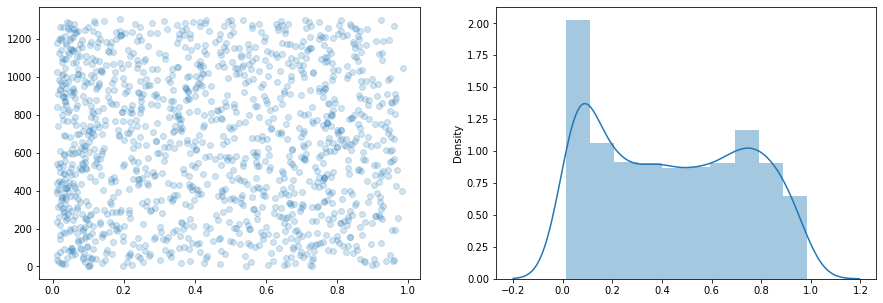

In [21]:
#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(y_pred,range(0,y_pred.shape[0]),alpha=0.2)
ax2=sns.distplot(y_pred)

In [22]:
cutoff=0.55

y_pred = np.where((y_pred >= cutoff),1,y_pred)
y_pred = np.where((y_pred < cutoff),0,y_pred)

labels = [0, 1]
print(classification_report(y_test.tolist(),y_pred.tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73       660
           1       0.74      0.59      0.66       644

    accuracy                           0.70      1304
   macro avg       0.71      0.70      0.69      1304
weighted avg       0.71      0.70      0.70      1304



In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[528, 132],
       [261, 383]])

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.6986196319018405

In [25]:
testdata2 = pd.read_csv('HYP-sarc-notsarc.csv')
testdata2.drop(columns=['id'],axis=1,inplace=True)
classes = {"notsarc" : 0,"sarc" : 1}
testdata2["class"] = testdata2["class"].map(classes)
testdata2 = testdata2[['text', 'class']]
testdata2['text'] = testdata2['text'].apply(clean_text)
onehot_repr2 = [one_hot(words,voc_size)for words in testdata2['text']] 
embedded_docs2 = pad_sequences(onehot_repr2,padding='pre',maxlen=sent_length)
y2=testdata2['class']
X2=np.array(embedded_docs2)
y2=np.array(y2)
y_pred2=model.predict(X2)

In [26]:
y_pred2 = np.where((y_pred2 >= cutoff),1,y_pred2)
y_pred2 = np.where((y_pred2 < cutoff),0,y_pred2)

In [27]:
print(classification_report(y2,y_pred2,labels=labels))

              precision    recall  f1-score   support

           0       0.61      0.57      0.59       582
           1       0.60      0.64      0.62       582

    accuracy                           0.61      1164
   macro avg       0.61      0.61      0.61      1164
weighted avg       0.61      0.61      0.61      1164



In [28]:
testdata3 = pd.read_csv('RQ-sarc-notsarc.csv')
testdata3.drop(columns=['id'],axis=1,inplace=True)
classes = {"notsarc" : 0,"sarc" : 1}
testdata3["class"] = testdata3["class"].map(classes)
testdata3 = testdata3[['text', 'class']]
testdata3['text'] = testdata3['text'].apply(clean_text)
onehot_repr3 = [one_hot(words,voc_size)for words in testdata3['text']] 
embedded_docs3 = pad_sequences(onehot_repr3,padding='pre',maxlen=sent_length)
y3=testdata3['class']
X3=np.array(embedded_docs3)
y3=np.array(y3)
y_pred3=model.predict(X3)

In [29]:
y_pred3 = np.where((y_pred3 >= cutoff),1,y_pred3)
y_pred3 = np.where((y_pred3 < cutoff),0,y_pred3)
print(classification_report(y3,y_pred3,labels=labels))

              precision    recall  f1-score   support

           0       0.65      0.80      0.72       851
           1       0.74      0.57      0.64       851

    accuracy                           0.69      1702
   macro avg       0.70      0.69      0.68      1702
weighted avg       0.70      0.69      0.68      1702



In [30]:
model.save('LSTM_Sarcasm_GEN_70', include_optimizer=True)

In [31]:
reloaded_model = tf.saved_model.load('LSTM_Sarcasm_GEN_70')